<a href="https://colab.research.google.com/github/JacopoMangiavacchi/FastLabeling/blob/master/pets_cats_dogs_transfer_learning_with_new_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import FastAI and PETS dataset

In [1]:
!pip install fastai -U

     |████████████████████████████████| 358kB 12.4MB/s 
ERROR: fastai 2.0.6 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'
Path.BASE_PATH = path
path.ls()

(#7393) [Path('Bengal_151.jpg'),Path('saint_bernard_171.jpg'),Path('yorkshire_terrier_125.jpg'),Path('Birman_111.jpg'),Path('leonberger_45.jpg'),Path('Sphynx_185.jpg'),Path('Ragdoll_159.jpg'),Path('wheaten_terrier_26.jpg'),Path('Bombay_14.jpg'),Path('Abyssinian_137.jpg')...]

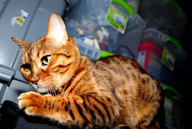

In [3]:
img = PILImage.create(path/'Bengal_12.jpg')
img.to_thumb(192)

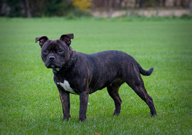

In [4]:
img = PILImage.create(path/'staffordshire_bull_terrier_13.jpg')
img.to_thumb(192)

# Prepare DataLoaders for PETS dataset with simply Cats and Dogs labels

In [5]:
def is_cat(x): return x[0].isupper()

cats_dogs_dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

cats_dogs_dls.train_ds, cats_dogs_dls.valid_ds

((#5912) [(PILImage mode=RGB size=500x290, TensorCategory(1)),(PILImage mode=RGB size=300x298, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=422x500, TensorCategory(1)),(PILImage mode=RGB size=380x500, TensorCategory(1)),(PILImage mode=RGB size=333x500, TensorCategory(1)),(PILImage mode=RGB size=500x333, TensorCategory(0)),(PILImage mode=RGB size=353x500, TensorCategory(0)),(PILImage mode=RGB size=335x500, TensorCategory(1)),(PILImage mode=RGB size=500x375, TensorCategory(1))...],
 (#1478) [(PILImage mode=RGB size=353x500, TensorCategory(0)),(PILImage mode=RGB size=500x333, TensorCategory(1)),(PILImage mode=RGB size=333x500, TensorCategory(1)),(PILImage mode=RGB size=399x313, TensorCategory(1)),(PILImage mode=RGB size=400x500, TensorCategory(0)),(PILImage mode=RGB size=500x333, TensorCategory(0)),(PILImage mode=RGB size=205x320, TensorCategory(1)),(PILImage mode=RGB size=432x500, TensorCategory(0)),(PILImage mode=RGB size=500x375, Tensor

In [6]:
cats_dogs_dls.vocab

(#2) [False,True]

# Train Full PETS Dataset on ResNet architecture with Cats and Dogs labels

In [7]:
learn = cnn_learner(cats_dogs_dls, resnet34, metrics=accuracy)
learn.fine_tune(3)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.180800,0.025750,0.991204,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.060349,0.033691,0.989175,00:48
1,0.038273,0.015631,0.996617,00:48
2,0.021013,0.010353,0.995940,00:48


# Prepare DataLoaders for a small subset of the PETS Dataset with real breed labels for only xx samples per class (xx order of magnitute smaller)

In [8]:
all_pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                     get_items=get_image_files, 
                     splitter=RandomSplitter(0.2, seed=42),
                     get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                     item_tfms=Resize(460),
                     batch_tfms=aug_transforms(size=224, min_scale=0.75))

all_pets_dls = all_pets.dataloaders(path)

all_pets_dls.train_ds, all_pets_dls.valid_ds, all_pets_dls.vocab

((#5912) [(PILImage mode=RGB size=500x290, TensorCategory(1)),(PILImage mode=RGB size=300x298, TensorCategory(17)),(PILImage mode=RGB size=500x375, TensorCategory(14)),(PILImage mode=RGB size=422x500, TensorCategory(9)),(PILImage mode=RGB size=380x500, TensorCategory(6)),(PILImage mode=RGB size=333x500, TensorCategory(6)),(PILImage mode=RGB size=500x333, TensorCategory(12)),(PILImage mode=RGB size=353x500, TensorCategory(19)),(PILImage mode=RGB size=335x500, TensorCategory(9)),(PILImage mode=RGB size=500x375, TensorCategory(7))...],
 (#1478) [(PILImage mode=RGB size=353x500, TensorCategory(18)),(PILImage mode=RGB size=500x333, TensorCategory(2)),(PILImage mode=RGB size=333x500, TensorCategory(4)),(PILImage mode=RGB size=399x313, TensorCategory(1)),(PILImage mode=RGB size=400x500, TensorCategory(20)),(PILImage mode=RGB size=500x333, TensorCategory(15)),(PILImage mode=RGB size=205x320, TensorCategory(3)),(PILImage mode=RGB size=432x500, TensorCategory(22)),(PILImage mode=RGB size=500x375

In [9]:
from shutil import copy2, rmtree
from glob import glob

subset_path = Path('./subset_pet')
rmtree(subset_path, ignore_errors=true)
subset_path.mkdir(exist_ok=True)

breed_dict = { breed : glob(str(path) + '/' + breed + '*')  for breed in all_pets_dls.vocab }

for breed in breed_dict:
  print(breed, len(breed_dict[breed]))

Abyssinian 203
Bengal 200
Birman 200
Bombay 200
British_Shorthair 200
Egyptian_Mau 200
Maine_Coon 200
Persian 200
Ragdoll 200
Russian_Blue 200
Siamese 200
Sphynx 200
american_bulldog 200
american_pit_bull_terrier 200
basset_hound 200
beagle 200
boxer 200
chihuahua 200
english_cocker_spaniel 200
english_setter 200
german_shorthaired 200
great_pyrenees 200
havanese 200
japanese_chin 200
keeshond 200
leonberger 200
miniature_pinscher 200
newfoundland 200
pomeranian 200
pug 200
saint_bernard 200
samoyed 200
scottish_terrier 199
shiba_inu 200
staffordshire_bull_terrier 191
wheaten_terrier 200
yorkshire_terrier 200


In [10]:
num_files_to_copy = 50

for breed in breed_dict:
  list_files = list(range(len(breed_dict[breed])))
  random.shuffle(list_files)
  for i in range(num_files_to_copy):
    copy2(breed_dict[breed][list_files[i]], subset_path)

In [11]:
subset_path.ls()

(#1850) [Path('subset_pet/saint_bernard_171.jpg'),Path('subset_pet/Sphynx_185.jpg'),Path('subset_pet/Abyssinian_137.jpg'),Path('subset_pet/Siamese_110.jpg'),Path('subset_pet/english_setter_17.jpg'),Path('subset_pet/pomeranian_44.jpg'),Path('subset_pet/scottish_terrier_13.jpg'),Path('subset_pet/pomeranian_181.jpg'),Path('subset_pet/samoyed_55.jpg'),Path('subset_pet/beagle_91.jpg')...]

In [12]:
subset_pets_dls = all_pets.dataloaders(subset_path)

subset_pets_dls.train_ds, subset_pets_dls.valid_ds, subset_pets_dls.vocab

((#1480) [(PILImage mode=RGB size=500x336, TensorCategory(16)),(PILImage mode=RGB size=189x300, TensorCategory(28)),(PILImage mode=RGB size=500x500, TensorCategory(18)),(PILImage mode=RGB size=500x489, TensorCategory(21)),(PILImage mode=RGB size=375x500, TensorCategory(14)),(PILImage mode=RGB size=225x300, TensorCategory(28)),(PILImage mode=RGB size=500x378, TensorCategory(27)),(PILImage mode=RGB size=275x275, TensorCategory(0)),(PILImage mode=RGB size=500x333, TensorCategory(35)),(PILImage mode=RGB size=500x333, TensorCategory(34))...],
 (#370) [(PILImage mode=RGB size=500x332, TensorCategory(33)),(PILImage mode=RGB size=375x500, TensorCategory(24)),(PILImage mode=RGB size=500x331, TensorCategory(16)),(PILImage mode=RGB size=500x375, TensorCategory(21)),(PILImage mode=RGB size=248x300, TensorCategory(29)),(PILImage mode=RGB size=300x225, TensorCategory(28)),(PILImage mode=RGB size=273x300, TensorCategory(17)),(PILImage mode=RGB size=200x182, TensorCategory(17)),(PILImage mode=RGB size

# Transfer Learning reusing the ResNet model previosly trained on Cats / Dogs labels and change last Linear learner to fine-tune on the xx digit labels and train on the new small subset dataset

In [18]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [19]:
learn.model[1] = create_head(1024, len(subset_pets_dls.vocab))

In [20]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [21]:
learn2 = Learner(subset_pets_dls, learn.model, metrics=accuracy)
learn2.fine_tune(20)


epoch,train_loss,valid_loss,accuracy,time
0,2.257910,9.131533,0.086486,00:17


epoch,train_loss,valid_loss,accuracy,time
0,1.022075,0.805249,0.754054,00:17
1,0.728663,0.829562,0.748649,00:17
2,0.588492,0.993478,0.700000,00:17
3,0.592032,2.638741,0.394595,00:17
4,0.710826,2.453174,0.429730,00:17
5,0.800289,2.329558,0.427027,00:17
6,0.824315,2.128325,0.443243,00:17
7,0.731169,1.315926,0.637838,00:17
8,0.637180,1.868378,0.508108,00:17
9,0.569775,1.727133,0.527027,00:17


# Classic Transfer Learning training from original ResNet on the new small subset dataset

In [22]:
learn3 = cnn_learner(subset_pets_dls, resnet34, metrics=accuracy)
learn3.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,3.476072,0.690289,0.783784,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.987381,0.477662,0.856757,00:17
1,0.802133,0.383165,0.870270,00:17
2,0.618630,0.300453,0.886486,00:17
3,0.480773,0.306400,0.902703,00:17
4,0.387324,0.320638,0.889189,00:17
5,0.302791,0.335695,0.883784,00:17
6,0.255699,0.327232,0.891892,00:17
7,0.208008,0.256033,0.921622,00:17
8,0.162924,0.347742,0.900000,00:17
9,0.132408,0.358987,0.897297,00:17


# Benchmarking the two models with the full MNIST validation dataset

In [23]:
learn2.validate(dl=all_pets_dls.valid)

(#2) [0.44024279713630676,0.8728010654449463]

In [24]:
learn3.validate(dl=all_pets_dls.valid)

(#2) [0.8561298251152039,0.7631934881210327]